In [2]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from sklearn.linear_model import LassoCV
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import scipy.special
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits import mplot3d

In [37]:
n = 10000
p = 10
mu = 0
sigma = 1
## Features
X = np.random.normal(mu, sigma, n*p).reshape(n,p)
print(X.shape)
## Treatment Assignments
T = np.random.binomial(1, 0.5, n)
#print(T)
## Output
Y = np.maximum(X[:,0],0) * T + X[:,1] + np.minimum(X[:,2],0)+np.random.normal(mu, sigma, n)
Y_sigmoid = [1/(1+math.exp(-y)) for y in Y]
Y_class = np.array([1 if y >=0.5 else 0 for y in Y_sigmoid])
print(Y.shape)
print(len(Y_sigmoid))
print(np.sum(Y_class))
print(Y)

(10000, 10)
(10000,)
10000
4479
[ 1.51043958  1.16011403 -0.80769287 ... -0.69855865 -0.50854628
 -2.14883506]


In [4]:
## Features
X_test = np.random.normal(mu, sigma, n*p).reshape(n,p)
#print(X.shape)
## Treatment Assignments
T_test = np.random.binomial(1, 0.5, n)
#print(W)
## Output
Y_test = np.maximum(X[:,0],0) * T + X[:,1] + np.minimum(X[:,2],0)+np.random.normal(mu, sigma, n)
Y_test_sigmoid = [1/(1+math.exp(-y)) for y in Y_test]
Y_test_class = np.array([1 if y >=0.5 else 0 for y in Y_test_sigmoid])
print(Y_test.shape)
print(len(Y_test_sigmoid))
print(np.sum(Y_test_class))

(10000,)
10000
4521


In [5]:
## Regression Casual Forests >> Classification Forests
CF = CausalForest(criterion='het', n_estimators=30,       
                      min_samples_leaf=10, 
                      max_depth=10, max_samples=0.5,subforest_size = 5)
CF = CF.fit(X = X,T= T,y = Y_class)
CF

CausalForest(criterion='het', fit_intercept=True, honest=True, inference=True,
             max_depth=10, max_features='auto', max_samples=0.5,
             min_balancedness_tol=0.45, min_impurity_decrease=0.0,
             min_samples_leaf=10, min_samples_split=10,
             min_var_fraction_leaf=None, min_var_leaf_on_val=False,
             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
             random_state=None, subforest_size=5, verbose=0, warm_start=False)

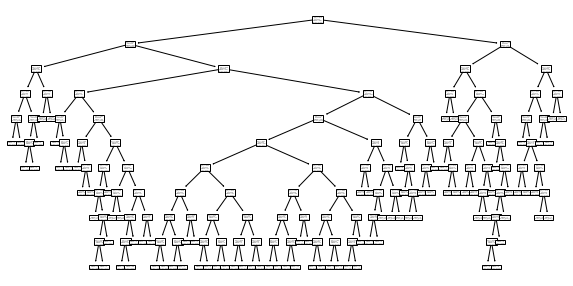

In [6]:
plt.figure(figsize=(10, 5))
plot_tree(CF.estimators_[1], impurity=True)
plt.show()

In [7]:
Train_Ind = CF.apply(X)
print(Train_Ind.shape)

(10000, 30)


In [8]:
Test_Ind = CF.apply(X_test)
print(Test_Ind)

[[ 25  41 127 ...  13  21 168]
 [216 169 178 ... 203 219 221]
 [164 135 156 ... 178 101 175]
 ...
 [ 59  62  80 ...  28 118 129]
 [124  61  99 ...  29  29  26]
 [120 123  54 ...  29  22  13]]


In [9]:
## Based on Forests/leave, calculate posterior for every leaf
def get_posterior(Forests_Estimator,X_train,Y_train):
    leaves_Ind = Forests_Estimator.apply(X)
    for j in range(0,leaves_Ind.shape[1]):
        leaves_Ind_j_o = np.array(pd.unique(leaves_Ind[:,j]))
        leaves_Ind_j = np.array([int(i) for i in leaves_Ind_j_o]).reshape(len(pd.unique(leaves_Ind[:,j])),1)
        #print(leaves_Ind_j)
        poster_ind_1 = []
        poster_ind_0 = []
        for ind in leaves_Ind_j:
            Y_ind = Y_train[leaves_Ind[:,j] == ind]
            #print(Y_ind.shape[0])
            #poster_ind.append(0)
            poster_ind_1.append(np.sum(Y_ind)/len(Y_ind))
            poster_ind_0.append(len(Y_ind[Y_ind == 0])/len(Y_ind))
        poster_ind_1 = np.array(poster_ind_1).reshape(len(pd.unique(leaves_Ind[:,j])),1)
        poster_ind_0 = np.array(poster_ind_0).reshape(len(pd.unique(leaves_Ind[:,j])),1)
        Forests_Estimator.estimators_[j].leaves_indicies = leaves_Ind_j.ravel()
        #print(leaves_Ind_j)
        Forests_Estimator.estimators_[j].posterior = np.hstack((leaves_Ind_j,poster_ind_0,poster_ind_1))
        #print(Forests_Estimator.estimators_[j].posterior.shape)
    return Forests_Estimator

In [10]:
## Based on sample to calculate posterior for every sample
## question whether return treatment?
def Posterior(X_evaluate,X_train,Y_train,Forests_Estimator):
    Train_Ind = Forests_Estimator.apply(X_train)
    Test_Ind = Forests_Estimator.apply(X_evaluate)
    Poster = np.zeros(Test_Ind.shape)
    for i in range(0,Test_Ind.shape[0]):
        Test_Ind_i = Test_Ind[i,:]
        for j in range(0,Test_Ind.shape[1]):
            Train_sample_j = Train_Ind[:,j][Train_Ind[:,j] == Test_Ind_i[j]]
            Y_ij = Y_train[Train_Ind[:,j] == Test_Ind_i[j]]
            T_ij = T[Train_Ind[:,j] == Test_Ind_i[j]]
            Poster[i,j] = np.sum(Y_ij)/len(Y_ij)
    return Poster

In [11]:
get_posterior(CF,X,Y_class)

CausalForest(criterion='het', fit_intercept=True, honest=True, inference=True,
             max_depth=10, max_features='auto', max_samples=0.5,
             min_balancedness_tol=0.45, min_impurity_decrease=0.0,
             min_samples_leaf=10, min_samples_split=10,
             min_var_fraction_leaf=None, min_var_leaf_on_val=False,
             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
             random_state=None, subforest_size=5, verbose=0, warm_start=False)

In [12]:
print(CF.estimators_[0].posterior)
print(CF.estimators_[0].leaves_indicies[0])

[[3.00000000e+01 6.25000000e-01 3.75000000e-01]
 [1.23000000e+02 4.83870968e-01 5.16129032e-01]
 [1.03000000e+02 6.19047619e-01 3.80952381e-01]
 [9.60000000e+01 7.75000000e-01 2.25000000e-01]
 [5.90000000e+01 7.33333333e-01 2.66666667e-01]
 [2.08000000e+02 3.91437309e-01 6.08562691e-01]
 [1.52000000e+02 5.46511628e-01 4.53488372e-01]
 [1.20000000e+02 7.30870712e-01 2.69129288e-01]
 [2.21000000e+02 1.61290323e-01 8.38709677e-01]
 [2.05000000e+02 3.63157895e-01 6.36842105e-01]
 [4.10000000e+01 5.68965517e-01 4.31034483e-01]
 [4.90000000e+01 7.50000000e-01 2.50000000e-01]
 [7.70000000e+01 9.23076923e-01 7.69230769e-02]
 [6.90000000e+01 5.06493506e-01 4.93506494e-01]
 [2.29000000e+02 1.58730159e-02 9.84126984e-01]
 [8.60000000e+01 5.26135390e-01 4.73864610e-01]
 [1.68000000e+02 9.13793103e-01 8.62068966e-02]
 [2.00000000e+01 5.90909091e-01 4.09090909e-01]
 [1.86000000e+02 4.83333333e-01 5.16666667e-01]
 [1.91000000e+02 4.03508772e-01 5.96491228e-01]
 [2.15000000e+02 2.73972603e-01 7.260273

In [13]:
Poster = Posterior(X,X,Y_class,CF)
Poster.shape

(10000, 30)

## Get Propensity Tree (with all training data)

In [14]:
## For Propensity Tree
## Select subset of Training Set to build a classisfication tree for {X,W}
# Data = np.hstack((X,T.reshape(n,1),Y.reshape(n,1)))
# print(Data.shape)
#Honest_Size = 0.5
# Data_structure = shuffle(Data[np.arange(0,n,2),:])
# print(Data_structure.shape)
# X_structure = Data_structure[:,0:10]
# W_structure = Data_structure[:,-2]
# Y_structure = Data_structure[:,-1]
k = 10 ## modify needed
Classifier_RF_T = RandomForestClassifier(n_estimators = 100, 
                                         min_samples_leaf = k,
                                         random_state = 0,
                                         bootstrap = True, 
                                         oob_score = True)
# fit the classifier with X and W data
Classifier_RF_T = Classifier_RF_T.fit(X, T)

## Calculate ATE for test sample:

In [15]:
leave_ind_T = Classifier_RF_T.apply(X)
print(leave_ind_T.shape)

(10000, 100)


In [16]:
Poster_PF_1 = Posterior(X,X,Y_class,Classifier_RF_T)
Poster_PF_0 = np.ones((Poster_PF_1).shape)-Poster_PF_1
print(Poster_PF_1)
print(Poster_PF_0)

[[0.47368421 0.16666667 0.4        ... 0.28571429 0.24242424 0.5       ]
 [0.38095238 0.625      0.07142857 ... 0.23529412 0.         0.52631579]
 [0.42105263 0.68181818 0.21428571 ... 0.33333333 0.91304348 0.52173913]
 ...
 [0.86956522 0.9047619  0.875      ... 0.8125     1.         0.93333333]
 [0.55       0.52777778 0.81481481 ... 0.7037037  0.72       0.875     ]
 [0.55       0.36       0.61111111 ... 0.4        0.55       0.15      ]]
[[0.52631579 0.83333333 0.6        ... 0.71428571 0.75757576 0.5       ]
 [0.61904762 0.375      0.92857143 ... 0.76470588 1.         0.47368421]
 [0.57894737 0.31818182 0.78571429 ... 0.66666667 0.08695652 0.47826087]
 ...
 [0.13043478 0.0952381  0.125      ... 0.1875     0.         0.06666667]
 [0.45       0.47222222 0.18518519 ... 0.2962963  0.28       0.125     ]
 [0.45       0.64       0.38888889 ... 0.6        0.45       0.85      ]]


In [17]:
Poster_PF_1.shape

(10000, 100)

In [18]:
get_posterior(Classifier_RF_T,X,Y_class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
print(Classifier_RF_T.estimators_[0].posterior.shape)
print(Classifier_RF_T.estimators_[0].leaves_indicies)

(494, 3)
[612  93 347 361 135 958 712 905 802 265 417 538 672 232 932  77 638 918
 293 505 838 318 978  35 376 511 577 713 613 492 668 115 251 192 449 386
 331 608 396 460 799 889 494 172 937 271 771  26 194 760 774  90 644 456
 578 145 845 116 969 943 653 223  83 523 401 227 354 128 602  21 790 643
 676  33 816 507 633 343 939 550 695 218 107 345 156  51 211 986 372 803
 632 402 498 746 170 944 858 571 825 828 923 879  73 752 782 650 580 559
 716 146 739 508 910 231 109 693 375 561 283 201 827 366 598 210 149 658
 399 472 727 786 282 493 499 919 158 599 954 551 745 947 751 983  72 627
  60 309 588 977 520 436 902   6 794 349 864 566 742 929 730 873 445 316
  17  38 788 979 664 895 815 416 953 950 202 474 313 623 176 545 665 353
 673  22 143 221 850 241 884 127 485 675 547 513 385 299 700 654 945 610
 851 781 314 325 836 840 152 419 371 811 475 322 795 689  75 269 111 229
 249 707 153 770  50 710 630 261 656 250 479 697 888  81  53 122 591 733
 162 437 190 471 335 930 965 694 715 514 9

In [20]:
Poster_con_1 = np.mean(Poster_PF_1,axis = 1)
Poster_con_0 = np.mean(Poster_PF_0,axis = 1)
len(Poster_con_0)

10000

In [21]:
## Calculate conditional entropy
entropy_con = 1/(len(Poster_con_1))*(np.sum(-(np.array([i*math.log(i) for i in Poster_con_1])+
                                              np.array([i*math.log(i) for i in Poster_con_0]))))
## Calculate entropy for Y
prob_y = np.sum(Y_class)/len(Y_class)
entropy_y = -(prob_y*math.log(prob_y)+(1-prob_y)*math.log(1-prob_y))

MI = entropy_y-entropy_con

In [22]:
MI

0.040192266467465876

In [23]:
entropy_con

0.6491656254326361

In [24]:
[int(i) for i in np.geomspace(100,10000,6)]

[100, 251, 630, 1584, 3981, 10000]

[100, 193, 372, 719, 1389, 2682, 5179, 10000]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


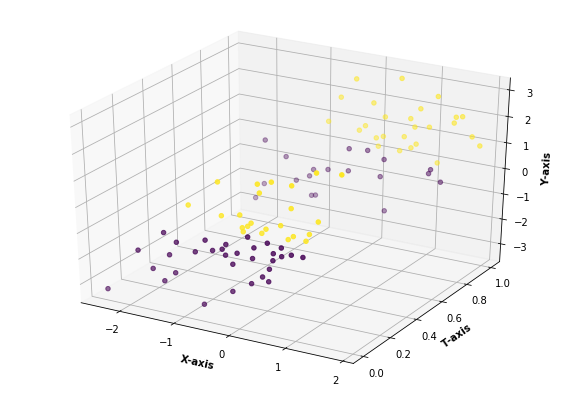

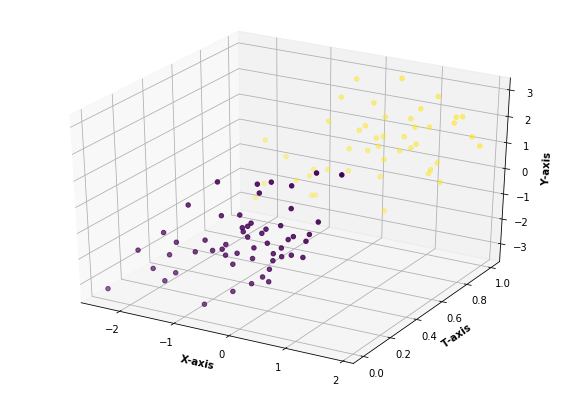

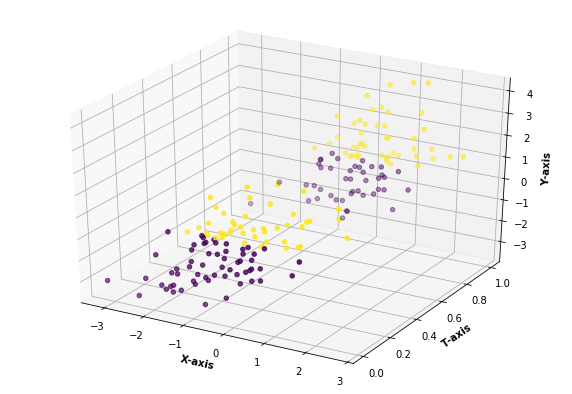

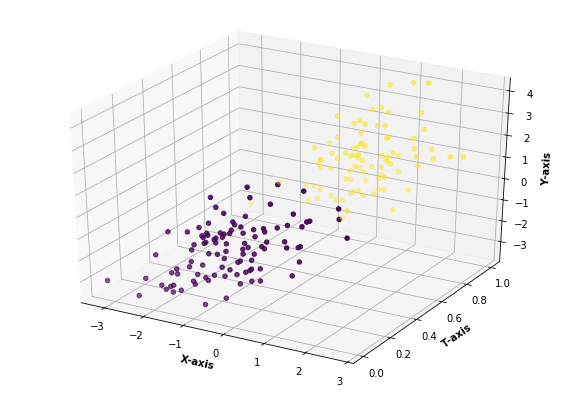

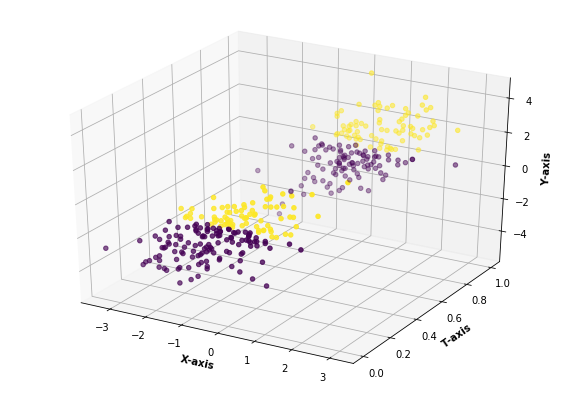

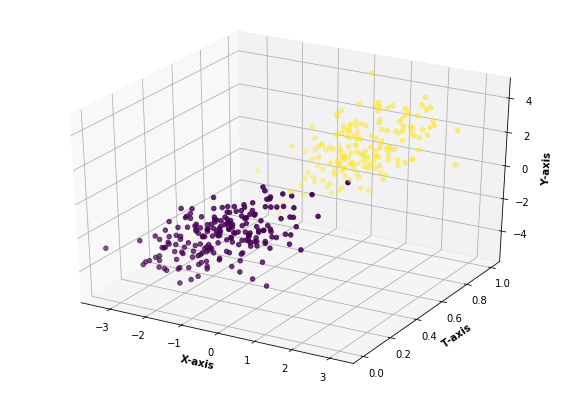

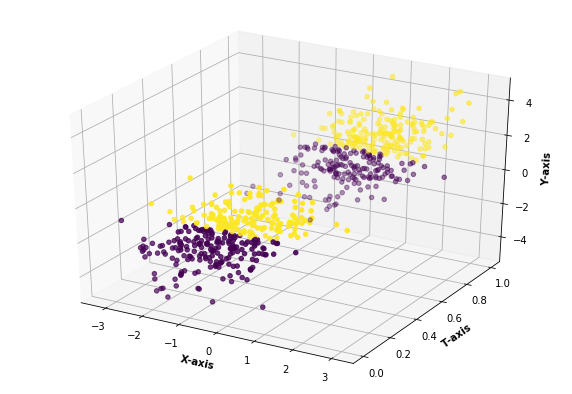

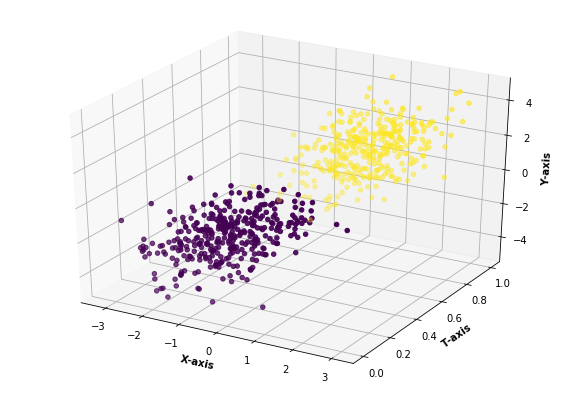

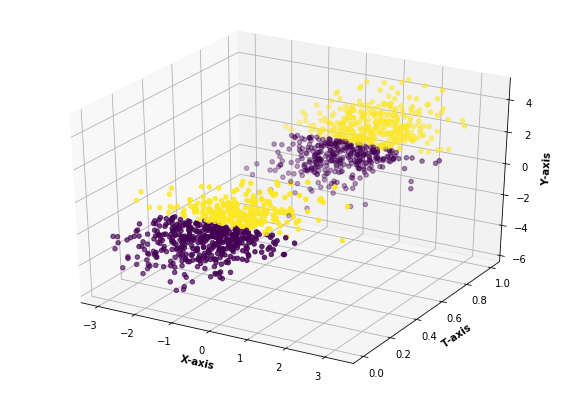

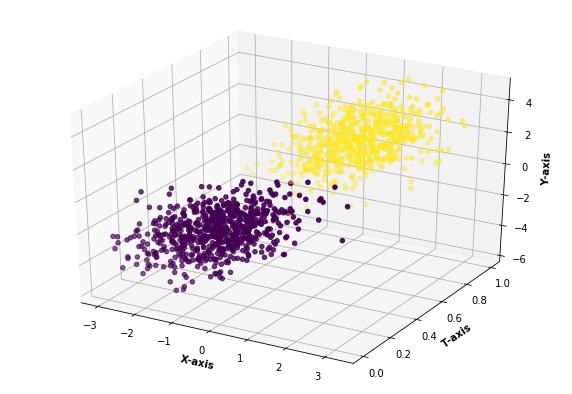

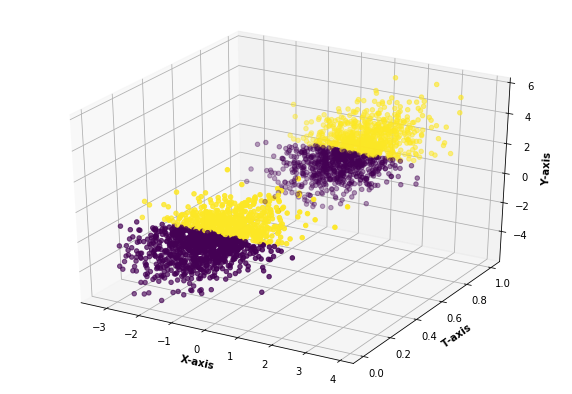

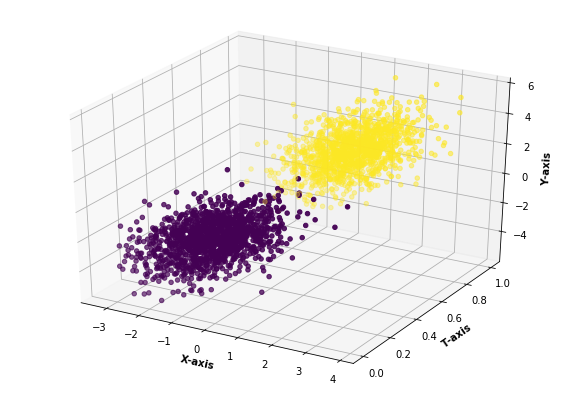

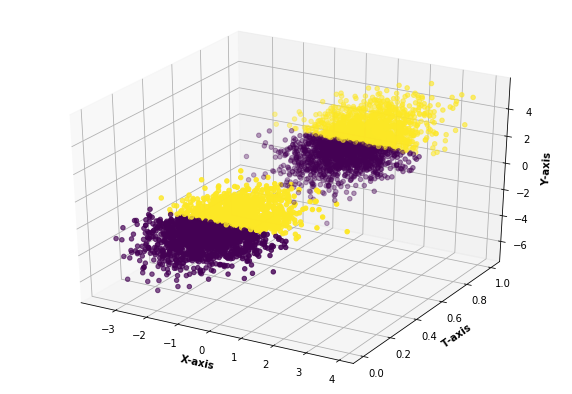

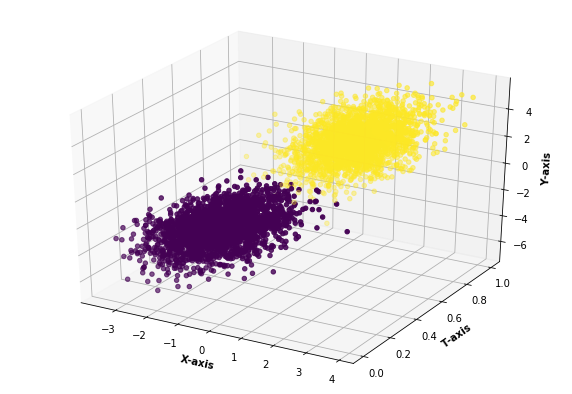

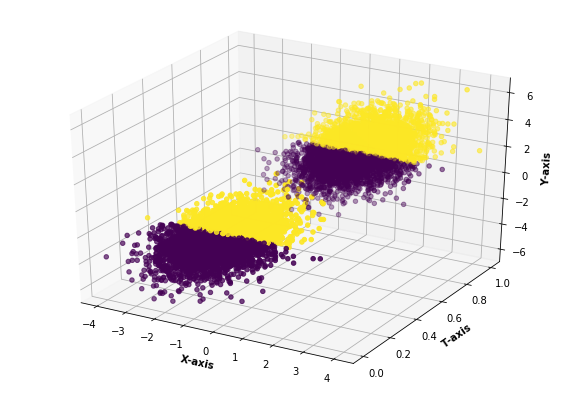

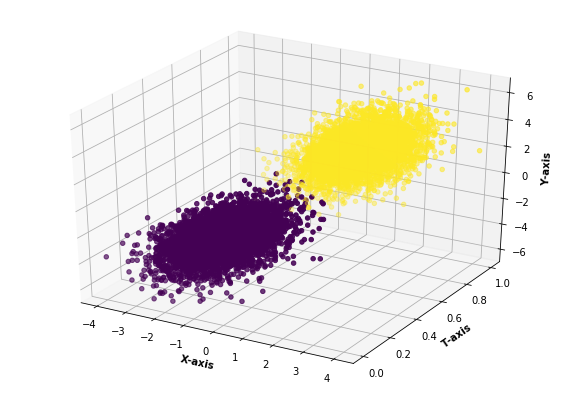

In [25]:
## Calculate entropy and mutual information with different sample size
sample_size = [int(i) for i in np.geomspace(100,10000,8)]
N = 50
print(sample_size)
k = 10 ## modify needed
MI_all = np.zeros((N,8))
entropy_con_all = np.zeros((N,8))
entropy_y_all = np.zeros((N,8))
for n_ite in range(0,N):
    print(n_ite)
    MI = []
    entropy_con = []
    entropy_y = []
    for sample_size_i in sample_size:
        ## get simulation
        n = sample_size_i
        p = 10
        mu = 0
        sigma = 1
        ## Features
        X = np.random.normal(mu, sigma, n*p).reshape(n,p)
        #print(X.shape)
        ## Treatment Assignments
        T = np.random.binomial(1, 0.5, n)
        #print(T)
        ## Output
        Y = np.maximum(X[:,0],0) * T + X[:,1] + np.minimum(X[:,2],0)+np.random.normal(mu, sigma, n)
        Y_sigmoid = [1/(1+math.exp(-y)) for y in Y]
        Y_class = np.array([1 if y >=0.5 else 0 for y in Y_sigmoid])
        
        #print(Y.shape)
        #print(len(Y_sigmoid))
        #print(np.sum(Y_class))

        ## Get Propensity Tree (with all training data)

        Classifier_RF_T = RandomForestClassifier(n_estimators = 100, 
                                                 min_samples_leaf = k,
                                                 random_state = 0,
                                                 bootstrap = True, 
                                                 oob_score = True)
        # fit the classifier with X and W data
        Classifier_RF_T = Classifier_RF_T.fit(X, T)
        leave_ind_T = Classifier_RF_T.apply(X)
        Poster_PF_1 = Posterior(X,X,Y_class,Classifier_RF_T)
        Poster_PF_0 = np.ones((Poster_PF_1).shape)-Poster_PF_1
        get_posterior(Classifier_RF_T,X,Y_class)
        Poster_con_1 = np.mean(Poster_PF_1,axis = 1)
        Poster_con_0 = np.mean(Poster_PF_0,axis = 1)

        ## Calculate conditional entropy
        entropy_con_i = 1/(len(Poster_con_1))*(np.sum(-(np.array([i*math.log(i) for i in Poster_con_1])+
                                                      np.array([i*math.log(i) for i in Poster_con_0]))))
        entropy_con.append(entropy_con_i)
        ## Calculate entropy for Y
        prob_y = np.sum(Y_class)/len(Y_class)
        entropy_y_i = -(prob_y*math.log(prob_y)+(1-prob_y)*math.log(1-prob_y))
        entropy_y.append(entropy_y_i)

        MI_i = entropy_y_i - entropy_con_i
        MI.append(MI_i)
        
        if n_ite == N-1:
            fig = plt.figure(figsize = (10, 7))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(X[:,1],T,Y,c = Y_class)
            ax.set_xlabel('X-axis', fontweight ='bold')
            ax.set_ylabel('T-axis', fontweight ='bold')
            ax.set_zlabel('Y-axis', fontweight ='bold')
            plt.show()
            
            fig = plt.figure(figsize = (10, 7))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(X[:,1],T,Y,c = T)
            ax.set_xlabel('X-axis', fontweight ='bold')
            ax.set_ylabel('T-axis', fontweight ='bold')
            ax.set_zlabel('Y-axis', fontweight ='bold')
            plt.show()
    
    MI_all[n_ite,:] = MI
    entropy_con_all[n_ite,:] = entropy_con
    entropy_y_all[n_ite,:] = entropy_y
    
    

average width of 95% CI is 0.004319960900414477


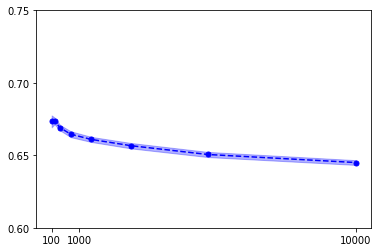

In [28]:
entropy_con_mean = np.mean(entropy_con_all,axis = 0)
entropy_con_low,entropy_con_up = stats.t.interval(0.95, N-1, loc=np.mean(entropy_con_all,axis = 0), scale=stats.sem(entropy_con_all,axis = 0))
plt.plot(sample_size,entropy_con_mean,'b--',marker='o', markersize=5)
plt.fill_between(sample_size,entropy_con_low,entropy_con_up,alpha = 0.3,color = 'blue')
width_Ture = np.mean(entropy_con_up-entropy_con_low)
print("average width of 95% CI is " + str(width_Ture))

plt.xticks([100,1000,10000])
plt.yticks(np.arange(0.6, 0.75, 0.05))
# plt.xlabel('Dimension')
# plt.ylabel('Score')
# plt.title('95% CI of True FI Score with Trunk with 500 Training Samples')
#plt.savefig("95% CI of True FI Score with Trunk with 500 Training Samples",bbox_inches = 'tight')
plt.show()



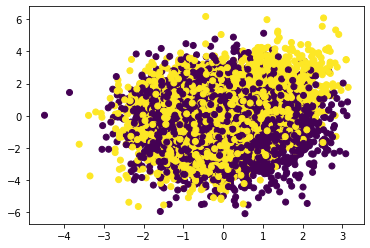

In [29]:
plt.scatter(X[:,0],Y,c = T)

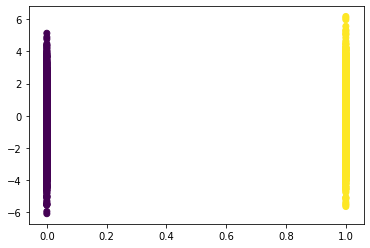

In [36]:
plt.scatter(T,Y,c = T)

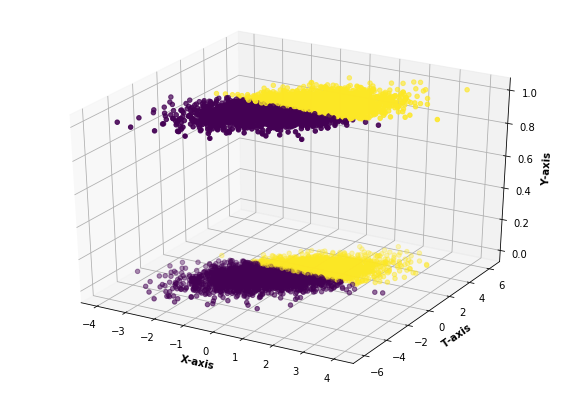

In [33]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,1],Y,T,c = Y_class)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('T-axis', fontweight ='bold')
ax.set_zlabel('Y-axis', fontweight ='bold')
plt.show()

average width of 95% CI is 0.002996472984772472


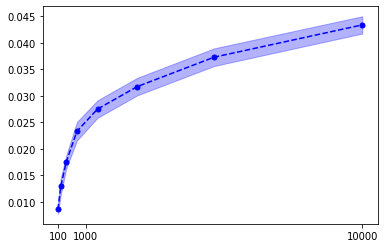

In [31]:
MI_mean = np.mean(MI_all,axis = 0)
MI_low,MI_up = stats.t.interval(0.95, N-1, loc=np.mean(MI_all,axis = 0), scale=stats.sem(MI_all,axis = 0))
plt.plot(sample_size,MI_mean,'b--',marker='o', markersize=5)
plt.fill_between(sample_size,MI_low,MI_up,alpha = 0.3,color = 'blue')
width_Ture = np.mean(MI_up-MI_low)
print("average width of 95% CI is " + str(width_Ture))

plt.xticks([100,1000,10000])
#plt.yticks(np.arange(0.6, 0.75, 0.05))
# plt.xlabel('Dimension')
# plt.ylabel('Score')
# plt.title('95% CI of True FI Score with Trunk with 500 Training Samples')
#plt.savefig("95% CI of True FI Score with Trunk with 500 Training Samples",bbox_inches = 'tight')
plt.show()

